In [31]:
import numpy as np 
from data.utils.modified_mdtw import (
generate_synthetic_data, prepare_person, local_distance, mdtw_distance, calculate_distance_matrix,
get_largest_event
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids



## Implementation of Modified Dynamic Time Warping 
The authors[1] introduced a novel distance metric called Modified Dynamic Time Warping (MDTW) - a technique designed to account not only for the nutritional content of meals but also their timing throughout the day.
In this notebook, I implemented the technique with Python and apply this to the synthetically generated data.

[1] Khanna, Nitin, et al. "Modified dynamic time warping (MDTW) for estimating temporal dietary patterns." 2017 IEEE Global Conference on Signal and Information Processing (GlobalSIP). IEEE, 2017.
### Quick Note on Classical Dynamic Time Warping (DTW)
Dynamic Time Warping (DTW) is a classic algorithm used to measure similarity between two sequences that may vary in length or timing. It's widely used in speech recognition, gesture analysis, and time series alignment. Let's see a very simple example of the Sequence A is aligned to Sequence B (shifted version of B) with using traditional dynamic time warping algorithm using fastdtw library. As input, we give a distance metric as Euclidean. Also, we put time series to calculate the distance between these time series and optimized aligned path.

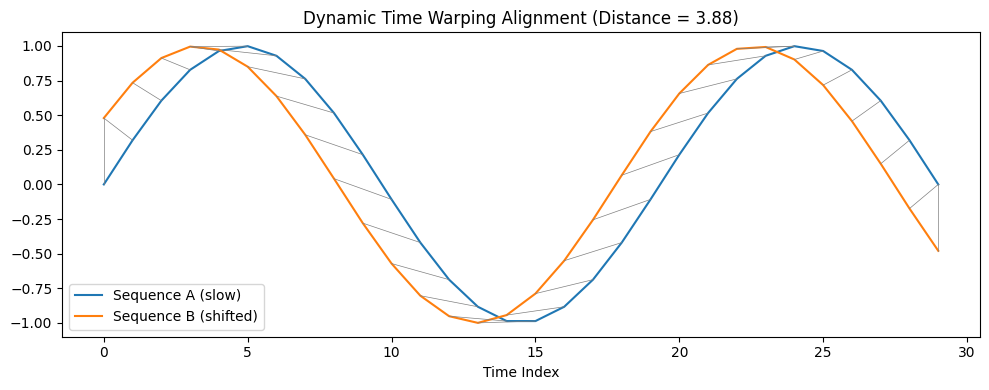

In [20]:

# Sample sequences (scalar values)
x = np.linspace(0, 3 * np.pi, 30)
y1 = np.sin(x)
y2 = np.sin(x+0.5)  # Shifted version
# Convert scalars to vectors (1D)
y1_vectors = [[v] for v in y1]
y2_vectors = [[v] for v in y2]
# Use absolute distance for scalars
distance, path = fastdtw(y1_vectors, y2_vectors, dist=euclidean)
#or for scalar 
# distance, path = fastdtw(y1, y2, dist=lambda x, y: np.abs(x-y))

distance, path = fastdtw(y1, y2,dist=lambda x, y: np.abs(x-y))
# Plot the alignment
plt.figure(figsize=(10, 4))
plt.plot(y1, label='Sequence A (slow)')
plt.plot(y2, label='Sequence B (shifted)')

# Draw alignment lines
for (i, j) in path:
    plt.plot([i, j], [y1[i], y2[j]], color='gray', linewidth=0.5)

plt.title(f'Dynamic Time Warping Alignment (Distance = {distance:.2f})')
plt.xlabel('Time Index')
plt.legend()
plt.tight_layout()
plt.savefig('dtw_alignment.png')
plt.show()

In [21]:


def create_time_series_plot(data,save_path=None):
    plt.figure(figsize=(10, 5))
    for person,record in data.items():
        #in case the nutrient vector has more than one dimension
        data=[[time, float(np.mean(np.array(value)))] for time,value in record.items()]

        time = [item[0] for item in data]
        nutrient_values = [item[1]*100 for item in data]
        # Plot the time series
        plt.plot(time, nutrient_values, label=person, marker='o')
    hours = list(range(24))
    hour_labels = [f"{(h % 12 or 12)}:00 {'AM' if h < 12 else 'PM'}" for h in hours]
    
    plt.xticks(hours, hour_labels, rotation=45)
    plt.xlim(0, 23)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Percentage of Calorie Intake (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)




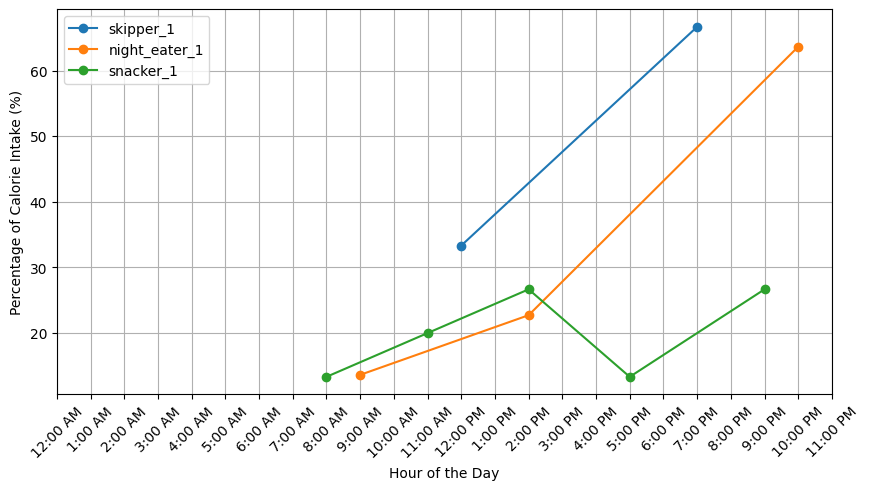

In [22]:
skipper={
    'person_id': 'skipper_1',
    'records': [
        {'time': 12, 'nutrients': [300]},  # Skipped breakfast, large lunch
        {'time': 19, 'nutrients': [600]},  # Large dinner
    ]
}
night_eater={
    'person_id': 'night_eater_1',
    'records': [
        {'time': 9, 'nutrients': [150]},   # Light breakfast
        {'time': 14, 'nutrients': [250]},  # Small lunch
        {'time': 22, 'nutrients': [700]},  # Large late dinner
    ]
}
snacker=  {
    'person_id': 'snacker_1',
    'records': [
        {'time': 8, 'nutrients': [100]},   # Light morning snack
        {'time': 11, 'nutrients': [150]},  # Late morning snack
        {'time': 14, 'nutrients': [200]},  # Afternoon snack
        {'time': 17, 'nutrients': [100]},  # Early evening snack
        {'time': 21, 'nutrients': [200]},  # Night snack
    ]
}
raw_data = [skipper, night_eater, snacker]
prepared_data = {person['person_id']: prepare_person(person) for person in raw_data}
create_time_series_plot(prepared_data)



[[0.         0.04634331 0.24403277]
 [0.04634331 0.         0.17888689]
 [0.24403277 0.17888689 0.        ]]


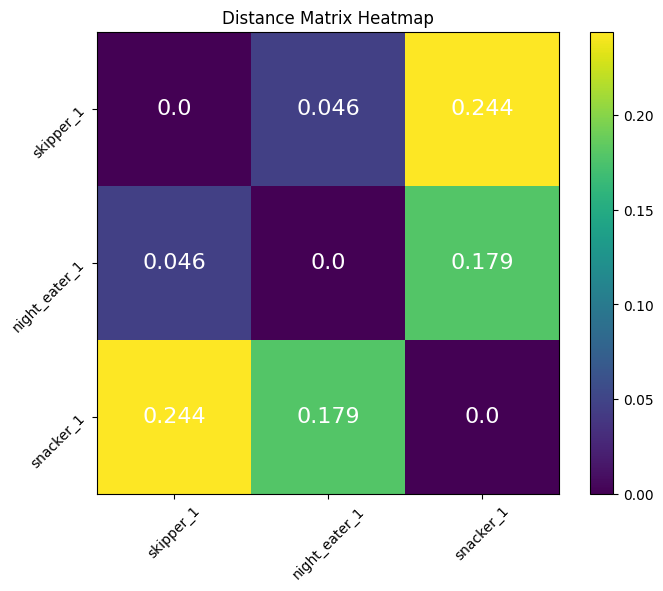

In [23]:

def plot_heatmap(matrix,people_ids,save_path=None):
    """
    Plot a heatmap of the distance matrix.  
    Args:
        matrix (np.ndarray): The distance matrix.
        title (str): The title of the plot.
        save_path (str): Path to save the plot. If None, the plot will not be saved.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
  
    plt.xticks(ticks=range(len(matrix)), labels=people_ids)
    plt.yticks(ticks=range(len(matrix)), labels=people_ids)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    ax = plt.gca()
    for (j,i),label in np.ndenumerate(matrix):
        ax.text(i,j,round(label,3),ha='center',va='center',color='white',fontsize=16)
    if save_path:
        plt.savefig(save_path)
    plt.title('Distance Matrix Heatmap')


distance_matrix = calculate_distance_matrix(prepared_data)
plot_heatmap(distance_matrix, list(prepared_data.keys()))
print(distance_matrix)

Let's generate more synthetic data

In [33]:
raw_data=generate_synthetic_data(num_people=100, min_meals=1, max_meals=5,min_calories=200,max_calories=800)
prepared_data = {person['person_id']: prepare_person(person) for person in raw_data}
print (prepared_data['person_1'])
distance_matrix = calculate_distance_matrix(prepared_data)

{0.0: [0.35718157181571814], 8.0: [0.2780487804878049], 16.0: [0.11978319783197831], 19.0: [0.24498644986449863]}


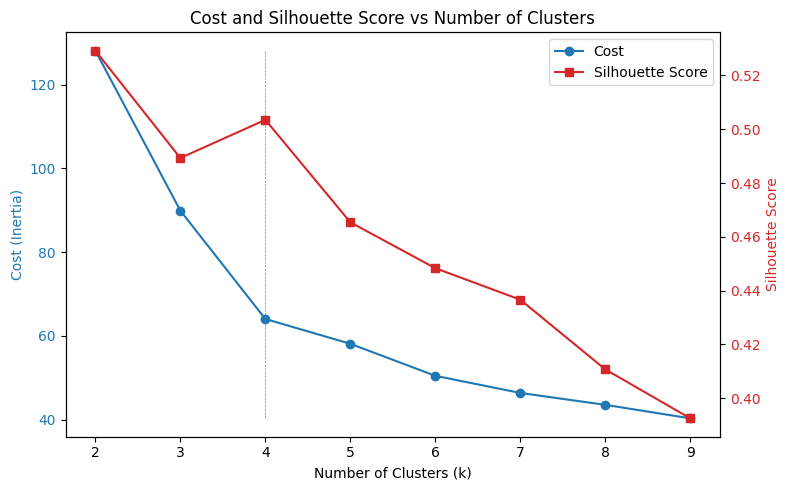

In [25]:

costs = []
silhouette_scores = []
for k in range(2, 10):
    model = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
    labels = model.fit_predict(distance_matrix)
    costs.append(model.inertia_)
    score = silhouette_score(distance_matrix, model.labels_, metric='precomputed')
    silhouette_scores.append(score)

# Plot
ks = list(range(2, 10))
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Cost (Inertia)', color=color1)
ax1.plot(ks, costs, marker='o', color=color1, label='Cost')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(ks, silhouette_scores, marker='s', color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

# Optional: combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.vlines(x=4, ymin=min(costs), ymax=max(costs), color='gray', linestyle='--', linewidth=0.5)

plt.title('Cost and Silhouette Score vs Number of Clusters')
plt.tight_layout()
plt.savefig('clustering_metrics_comparison.png')
plt.show()


In [26]:
# Kmedoids clustering with the optimal number of clusters
from sklearn_extra.cluster import KMedoids
k=4
model = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
labels = model.fit_predict(distance_matrix)

    


In [32]:

# Create a largest meal data per cluster
data_per_cluster = {i: [] for i in range(k)}
for i, person_id in enumerate(prepared_data.keys()):
    cluster_id = labels[i]
    print (prepared_data[person_id])
    t, v = get_largest_event(prepared_data[person_id])
    data_per_cluster[cluster_id].append((t, v))







{0.0: [0.35718157181571814], 8.0: [0.2780487804878049], 16.0: [0.11978319783197831], 19.0: [0.24498644986449863]}
{7.0: [0.3537037037037037], 10.0: [0.24953703703703703], 12.0: [0.13472222222222222], 19.0: [0.262037037037037]}
{0.0: [0.20798226164079822], 8.0: [0.20842572062084258], 19.0: [0.29046563192904656], 23.0: [0.29312638580931266]}
{1.0: [0.22334096109839818], 4.0: [0.2645308924485126], 9.0: [0.3153318077803204], 10.0: [0.19679633867276888]}
{3.0: [0.3285024154589372], 18.0: [0.6714975845410628]}
{0.0: [0.44045584045584046], 21.0: [0.12934472934472935], 23.0: [0.4301994301994302]}
{13.0: [0.27113361901051813], 14.0: [0.24970783015192832], 15.0: [0.2972341254382548], 18.0: [0.1819244253992988]}
{10.0: [0.3492407809110629], 14.0: [0.6507592190889371]}
{4.0: [0.22956289622956288], 7.0: [0.2502502502502503], 9.0: [0.17917917917917917], 13.0: [0.22422422422422422], 17.0: [0.11678345011678345]}
{7.0: [0.5594306049822064], 14.0: [0.4405693950177936]}
{5.0: [0.3104097974564296], 6.0: [

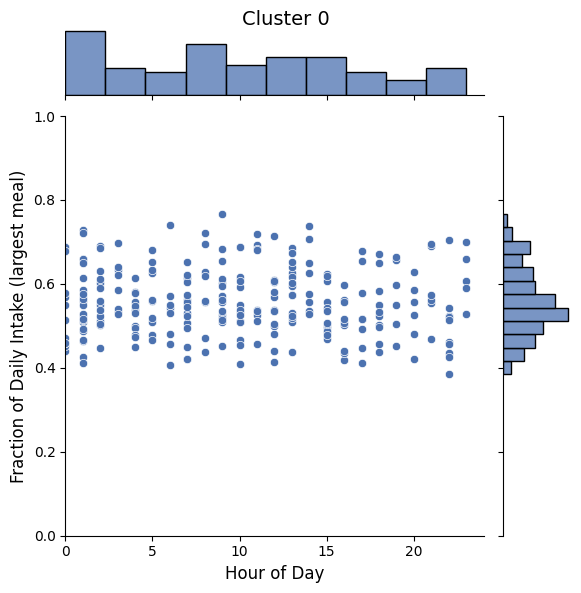

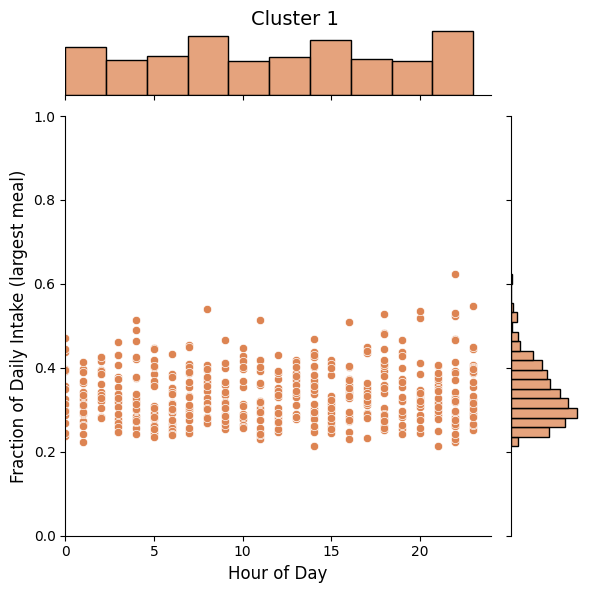

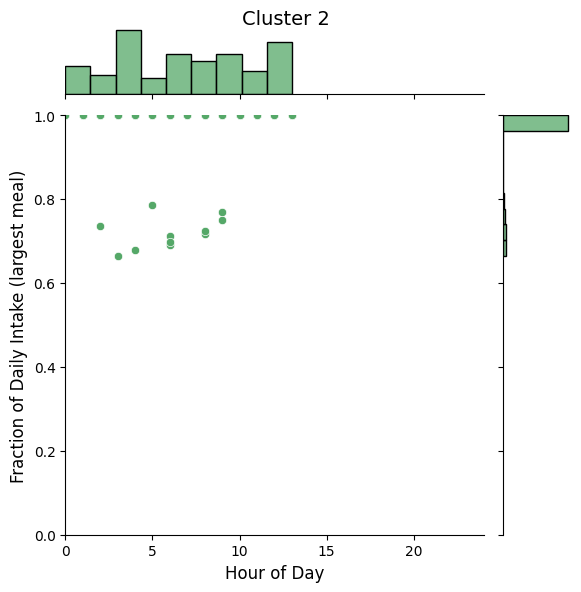

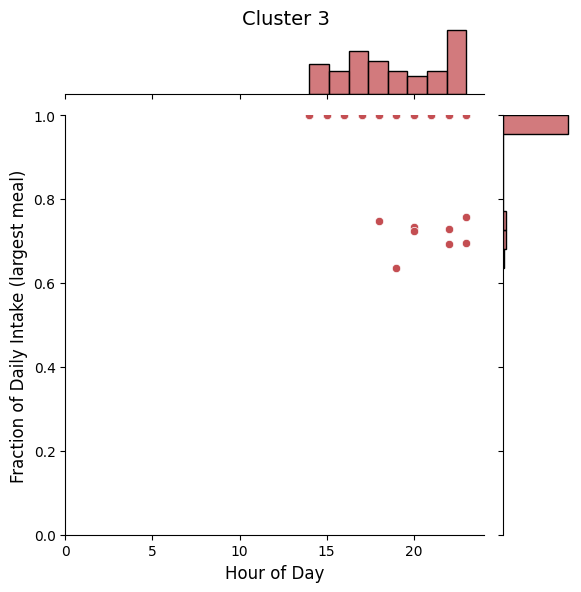

In [28]:
# Convert to pandas DataFrame
rows = []
for cluster_id, values in data_per_cluster.items():
    for hour, fraction in values:
        rows.append({"Hour": hour, "Fraction": fraction, "Cluster": f"Cluster {cluster_id}"})
df = pd.DataFrame(rows)
# Cluster_name=['Flexible or Irregular Eaters','Frequent Light Eaters','Early Heavy Eaters','Late Heavy Eaters']
# Plot each cluster using seaborn.jointplot
for cluster_label in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster_label]
    
    g = sns.jointplot(
        data=cluster_data,
        x="Hour",
        y="Fraction",
        kind="scatter",
        height=6,
        color=sns.color_palette("deep")[int(cluster_label.split()[-1])]
    )
    g.fig.suptitle(cluster_label, fontsize=14)
    g.set_axis_labels("Hour of Day", "Fraction of Daily Intake (largest meal)", fontsize=12)
    g.fig.tight_layout()
    g.ax_joint.set_xlim(0, 24)     # Set x-axis limits
    g.ax_joint.set_ylim(0, 1)      # Set y-axis limits
    g.fig.subplots_adjust(top=0.95)  # adjust title spacing
    plt.show()

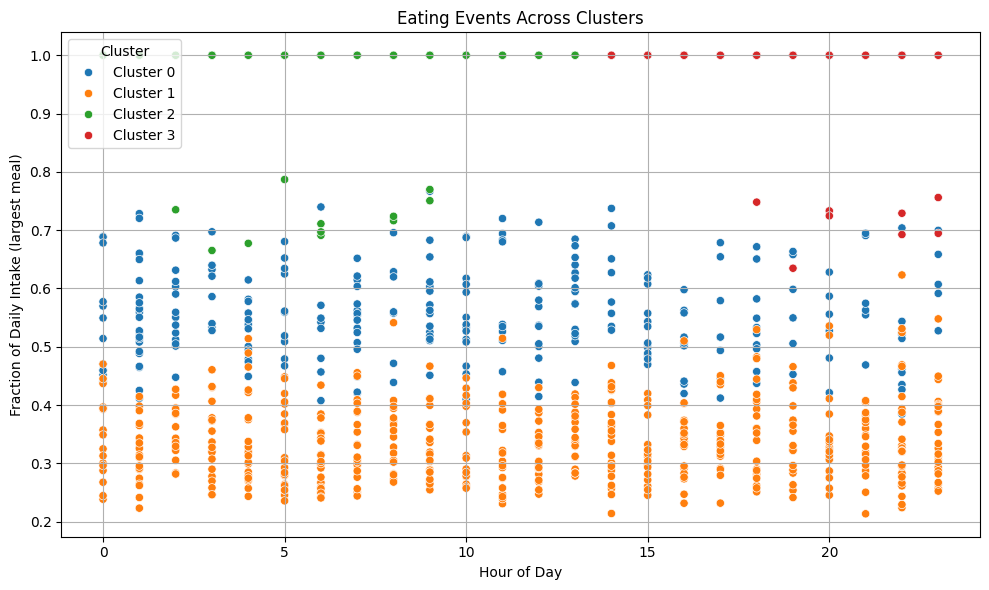

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Hour", y="Fraction", hue="Cluster", palette="tab10")
plt.title("Eating Events Across Clusters")
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Daily Intake (largest meal)")
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4914/1271488283.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Cluster', palette='pastel')


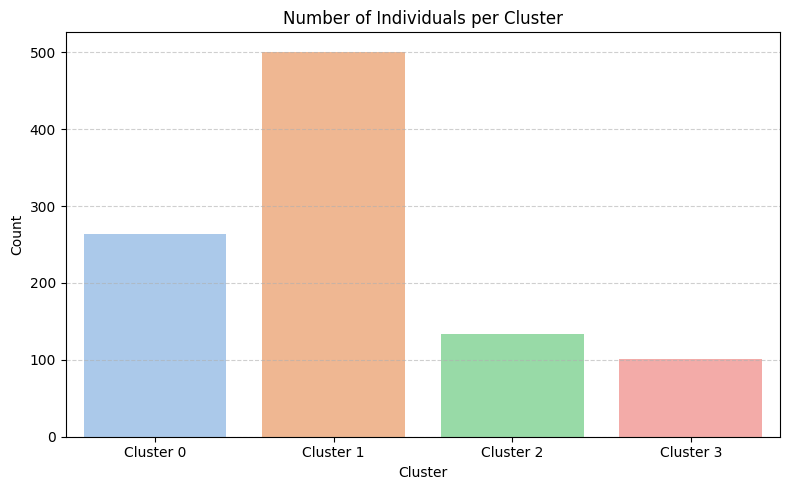

In [30]:

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Cluster', palette='pastel')

plt.title("Number of Individuals per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()